In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/home/yj/.pyenv/versions/3.6.5/envs/eeg/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/yj/.pyenv/versions/3.6.5/envs/eeg/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
torch.cuda.is_available()

True

### 1. Load dataset 


In [3]:
data_type = "SEED" # "DEAP"

n_channel = 1
bs = 64
model_type ="cla" # "reg"
numOfClass = 3 

# only DEAP
target = 0 # (V=0, A=1, D=2, L=3)

In [4]:
file_path = "DEAP_fftMap_60sec_0over.pickle"
file_path = "Result/fftMap_10sec_9over.pickle" 
file_path = "Result/SEED_fftMap_10sec_5over.pickle"
meta_path = "Result/SEED_10sec_5over"

with open(file_path, 'rb') as f:
    eeg_dataset = pickle.load(f)

if data_type == "SEED":
    with open(meta_path + "_ptc_to_idx", 'rb') as f:
        ptc_to_idx = pickle.load(f)
    with open(meta_path + "_idx_to_ptc", 'rb') as f:
        idx_to_ptc = pickle.load(f)

#### label 전처리

In [10]:
def compute_label(val, numOfClass=2): # DEAP
    # 2 class
    if numOfClass == 2:
        if val > 5:
            return 1
        else:
            return 0
    # 3 class
    elif numOfClass == 3:
        if val > 6:
            return 2 # high
        elif val < 4:
            return 0 # low
        else:
            return 1 # neutral

if model_type == "cla": 
    for i in range(len(eeg_dataset)):
        if data_type == "DEAP":
            V, A, D, L = eeg_dataset[i][1]
            V = compute_label(V, numOfClass); D = compute_label(D, numOfClass); 
            A = compute_label(A, numOfClass); L = compute_label(L, numOfClass);
            eeg_dataset[i][1] = [V,A,D,L]
        elif data_type == "SEED":
            eeg_dataset[i][1] += 1

### 2. Train Test split

In [11]:
if data_type == "DEAP":
    noc = len(eeg_dataset)//1280 # num of chunks
    print(noc)

    def get_data_index(p_id, t_id, c_id=0, noc=1):
        return (noc * 40) * p_id + noc * t_id + c_id

    def get_base_index(p_id, t_id):
        return 40 * p_id + t_id

    # get p_id, t_id, c_id
    def from_data_index(index, noc=1):
        p_id,remain = index // (noc*40), index % (noc*40)
        return p_id, remain//noc, remain%noc

elif data_type == "SEED":
    def get_data_index(p_id, t_id, c_id):
        return ptc_to_idx[str(p_id+1) + "-" + str(t_id) + "-" + str(c_id)]

    def get_base_index(p_id, t_id):
        return 15 * p_id + t_id

    # get p_id, t_id, c_id
    def from_data_index(index):
        return idx_to_ptc[index]

#### 1. 8:2 split

In [26]:
train, test = train_test_split(eeg_dataset, test_size=0.2)

#### 2. LOOCV

In [70]:
train = []; test = []

target = 0 # V,A,D,L
test_subject = 2
#test_trial = 20


if data_type == "DEEP":
    for p_id in range(0, 32):
        for t_id in range(0, 40):
            for c_id in range(0, noc):
                #if t_id == test_trial:
                if p_id == test_subject:
                    test.append(eeg_dataset[get_data_index(p_id, t_id, c_id, noc)])
                else:
                    train.append(eeg_dataset[get_data_index(p_id, t_id, c_id, noc)])


elif data_type == "SEED":
    for ptc, idx in ptc_to_idx.items():
        p_id, t_id, c_id = ptc.split("-")

        if int(p_id)-1 == test_subject:
            test.append(eeg_dataset[idx])
        else:
            train.append(eeg_dataset[idx])

In [71]:
# Test set balance
label_count = {0:0, 1:0, 2:0}
for dat in test:
    if data_type == "DEAP":
        label_count[dat[1][target]] += 1
    elif data_type == "SEED":
        label_count[dat[1]] += 1
label_count

{0: 212, 1: 210, 2: 223}

* data 가 1d array 인 경우. dimension 추가

In [72]:
# for i in range(len(train)):
#     train[i][0] = np.expand_dims(train[i][0], axis=0)

# for i in range(len(test)):
#     test[i][0] = np.expand_dims(test[i][0], axis=0)

#### compute mean, std

In [73]:
n_data = len(train) # 1280

mean_sum_list = [0 for i in range(0, n_channel)] # [0,0,0,0,0]
std_sum_list = [0 for i in range(0, n_channel)]

data_list = [x[0] for x in train]

# compute mean,std for each channel for each trial
train_mean = np.mean(np.asarray(data_list), axis=(0,1,2)) # length : 5
train_std = np.std(np.asarray(data_list), axis=(0,1,2))

if train_mean.shape == ():
    train_mean = tuple([train_mean])
    train_std = tuple([train_std])
    
print(train_mean)
print(train_std)

(0.024390243902439015,)
(0.014438263685051644,)


### 3. Custom Dataset Class

In [74]:
class EEG_Dataset(Dataset):
    # load, split
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        # 여기서 transform을 한번에 수행해도 됨----
        
        # -----------------------------------------
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        if data_type == 'DEAP':
            spectro, label = self.data_list[idx][0], self.data_list[idx][1][target]
        elif data_type == 'SEED':
            spectro, label = self.data_list[idx][0], self.data_list[idx][1]

        
        if self.transform:
            spectro = self.transform(spectro)
            
        return spectro, label

transform = transforms.Compose(
    [transforms.ToTensor()]) # H*W*C ndarray ==ToTensor()==> C*H*W tensor 
     #transforms.Normalize(train_mean, train_std)])
     #transforms.Normalize((0.5,), (0.5,))]) 

trainset = EEG_Dataset(train, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)

testset = EEG_Dataset(test, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)

classes = ('low', 'high')

torch.Size([64, 1, 32, 41])


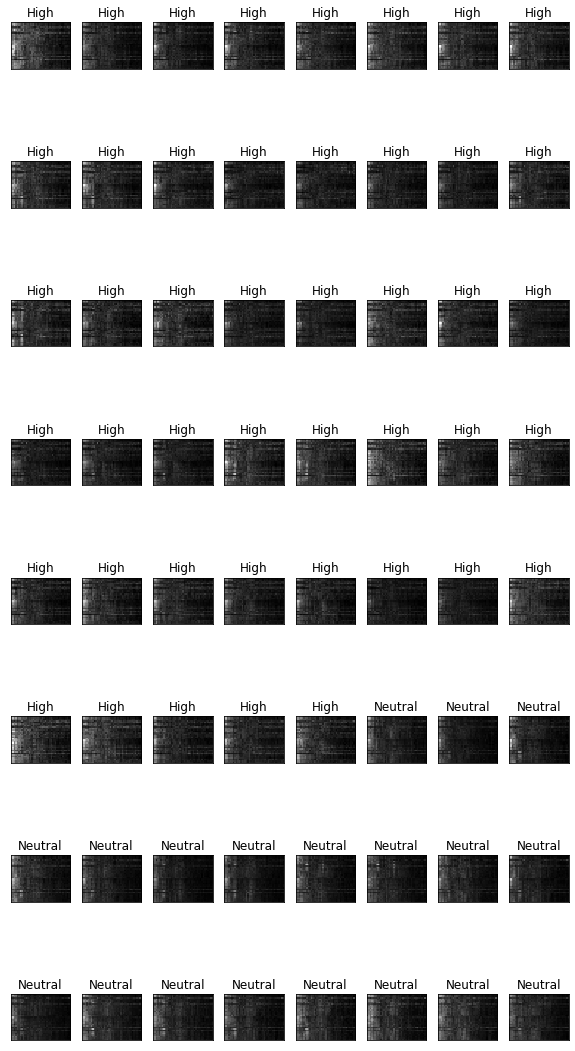

In [75]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

print(images.shape) # (16 * 5 * 65 * 125)  # (16 * 1 * 32 * 193)

base = (8, 8)

# ===plot =========================================
plt.figure(figsize=(10,20))
for i in range(0, bs): # image = (5, 65, 125)
    for ch in range(0, n_channel):
        frame = images[i][ch] # 65 * 125    # 32 * 193
        x_y = i//base[1], i%base[1]

        plt.subplot2grid(base, x_y)

        if numOfClass == 2:
            title_dict = {0:"Low", 1:"High"}
        elif numOfClass == 3:
            title_dict = {0:"Low", 1:"Neutral", 2:"High"}

        if model_type == "reg":
            plt.title("High" if labels[i].item() > 5 else "Low")
        else:
            plt.title(title_dict[labels[i].item()])
            
        fig = plt.imshow(frame, cmap='gray')

        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
# ==============================================

### 4. Define Model

In [76]:
import torch.nn as nn
import torch.nn.functional as F

lin_len = 884 # 592 #(채널 8)
out_len = 1 if model_type == "reg" else numOfClass

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2) 
        
        self.batch1 = nn.BatchNorm2d(8)
        self.conv1 = nn.Conv2d(n_channel, 8, 3) 

        self.batch2 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(8, 4, 3)
        
        self.fc1 = nn.Linear(lin_len, 64)
        self.fc2 = nn.Linear(64, out_len) 

    def forward(self, x):
        # conv => batch => pool => relu
        x = F.relu(self.pool(self.batch1(self.conv1(x)))) 
        x = self.conv2(x)

        x = x.view(-1, lin_len)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        if model_type == "reg":
            return x
        else:
            return F.softmax(x, dim=1)

### Train Model

#### Initialization

In [77]:
# models
net = CNN().float()

# optimizer, lossfunction
if model_type == "cla":
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay = 1e-5)
elif model_type == "reg":
    criterion = nn.MSELoss() 
    criterion = nn.SmoothL1Loss() #
    optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay = 1e-5)

#### Training

In [1]:
t_loss_list = []
v_loss_list = []
f1_list = []
acc_list = []

prev_acc = 0

for epoch in range(500):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs.float()) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    t_loss = running_loss/len(trainloader.dataset)
    print("\n[ Epoch %d ] T_Loss = %f \n"%(epoch+1, t_loss), end='' )
    
    try:
        val_loss, acc, f1 = testModel(net)
    except:
        continue

    if acc > prev_acc:
        #model_path = "trained_torch_models"+str(epoch)+"epoch.pth"
        #torch.save(net.state_dict(), model_path)
        prev_acc = acc
  
    t_loss_list.append(running_loss/len(trainloader.dataset))
    v_loss_list.append(val_loss)
    acc_list.append(acc)
    f1_list.append(f1)
print('Finished Training')
# ==================================================================

#### Test Model

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

if numOfClass == 2:
    target_names = ['Low', "High"]
elif  numOfClass == 3:
    target_names = ['Low', 'Neutral', 'High']

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()
        

def testModel(net, detail=False):
    co = 0 # 맞은 개수
    to = 0 # 테스트셋 개수

    # [[0,0,0], [0,0,0], [0,0,0]] 
    conf_mat = [[0 for i in range(numOfClass)] for j in range(numOfClass)] 

    
    all_label = []
    all_out = []
    with torch.no_grad():
        running_loss = 0
        for data in testloader:
            images, labels = data
            outputs = net(images.float()) # ****

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Update Confusion Matrix ==============================
            for i in range(len(outputs)):
                to += 1
                # ===============================print
                if detail:
                    if to <= 10:
                        print("Output : ", outputs[i])
                        print("Label : ", labels[i])
                    else: break
                # =====================================

                if model_type == "cla":
                    predicted = np.argmax(np.array(outputs[i])); 
                    label = labels[i].item()
                elif model_type == "reg":
                    predicted = 0 if outputs[i] < 5 else 1
                    label = 0 if labels[i].item() < 5 else 1
                
                all_label.append(label)
                all_out.append(predicted)
                
                conf_mat[predicted][label]+=1
                
                if predicted == label: 
                    co += 1
          # ===========================================================
        loss = running_loss/len(testloader.dataset)
        acc = 100 * (co / to)

        cm = confusion_matrix(all_label, all_out, labels = [i for i in range(0,numOfClass)])
        print_cm(cm, target_names)
        #print(classification_report(all_label, all_out, target_names=target_names))
        print("V_loss = %.06f  Acc = %.04f "%(loss, acc))
        
        return loss, acc, 1 #f1_score
testModel(net)